# Transporter analysis of bacillus mother-spore

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
sys.path.append('/home/UCSD/cobra_utils')
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from bacillusme.util.helper_functions import *

import copy

%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)
ecoli_files = dirname(abspath(bacillusme.__file__))

/home/jt/Downloads/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/Downloads/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


In [2]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [3]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [4]:
# Previously identified essential metabolites
exchange_list = ['4fe4s_s','2fe2s_s','udcpp_s','pydx5p_s','3fe4s_s','cl_s','sheme_s','cu_s','mn2_s',
                 'bmocogdp_s','dpm_s','thmpp_s','zn2_s','cbl1_s','cobalt2_s']
additional = [m.id for m in sporeme.metabolites if isinstance(m,cobrame.Metabolite)]
transported_metabolites = exchange_list+additional

In [5]:
# Get transport reactions
transport_reactions = []
for m in tqdm(transported_metabolites):
    transport_reactions_of_met = get_transport_reactions(sporeme,m,comps=['c','s']) +\
                                    get_transport_reactions(sporeme,m,comps=['s','c'])

    [transport_reactions.append(t.id) for t in transport_reactions_of_met]

100%|██████████| 1776/1776 [12:31<00:00,  2.36it/s]  


In [ ]:
transport_reactions = list(set(transport_reactions))

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,transport_reactions, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma')
flux_results_df.to_csv('comm_transport_flux_results.csv')

In [116]:
flux_results_df = pd.read_csv('comm_transport_flux_results.csv',index_col=0).drop('base',axis=1)

In [117]:
output = flux_results_df.loc[flux_results_df.columns.to_list()+['biomass_dilution_s']]
output = output[output.any(axis=1)] # Only reactions that carried flux in at least one knockout

<Figure size 936x360 with 0 Axes>

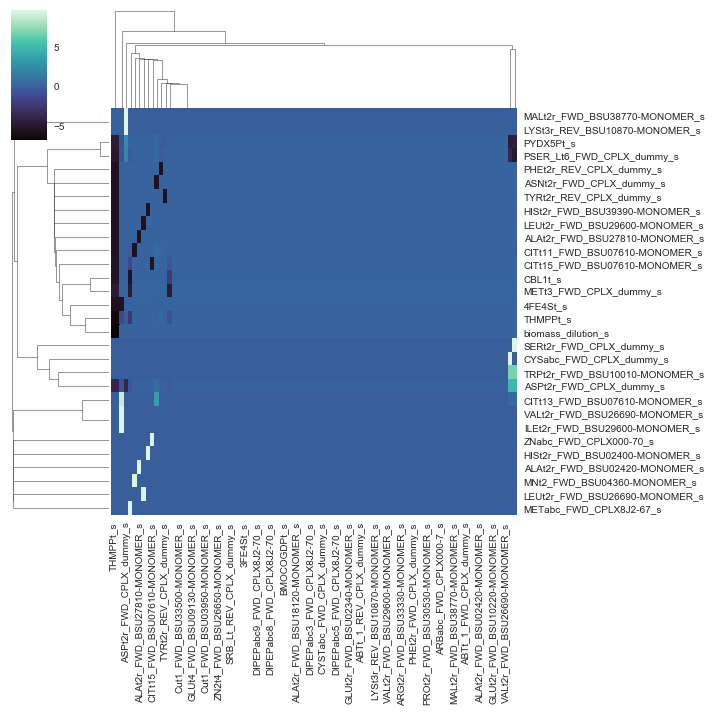

In [121]:
plt.figure(figsize = (13,5))
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
sns.clustermap(cluster_df,col_cluster=1,row_cluster=1,cmap='mako')
plt.savefig('clustermap_unfiltered')
# Check normalization Z-score, is it normalizing all elements in the matrix or only row-wise?

<Figure size 936x360 with 0 Axes>

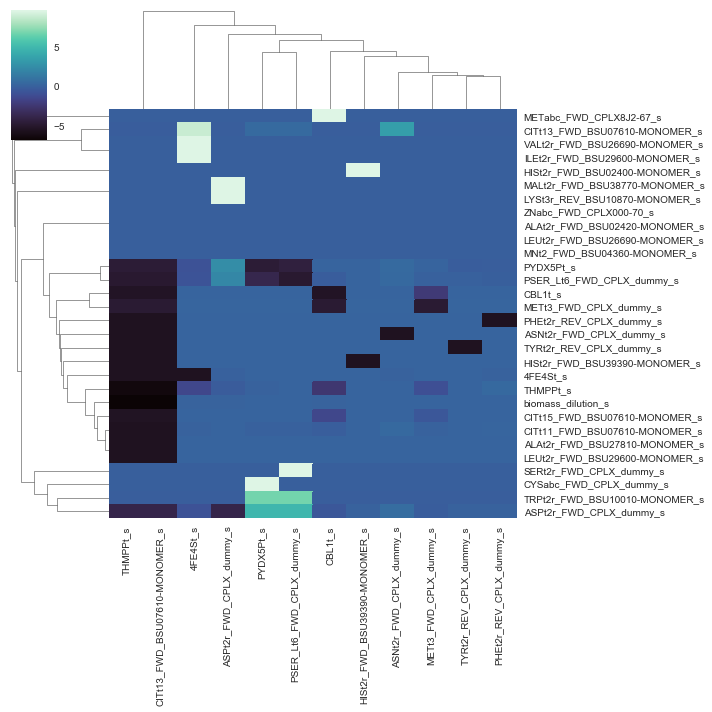

In [122]:
plt.figure(figsize = (13,5))
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
cluster_df = cluster_df.loc[:,output.loc['biomass_dilution_s']<bins[-1]]
sns.clustermap(cluster_df,col_cluster=1,row_cluster=1,cmap="mako")
plt.savefig('clustermap_filtered')

Identify essential transporters so far. These are stored and taken out as they are already results.

In [119]:
essential_transporters = list(output.columns[output.loc['biomass_dilution_s'] < 0.001])
candidates_df = output.drop(essential_transporters,axis=1)
print('So far, two transporters are obviously essential: {}'.format(essential_transporters))

So far, two transporters are obviously essential: ['THMPPt_s', 'CITt13_FWD_BSU07610-MONOMER_s']


Text(0, 0.5, 'Counts')

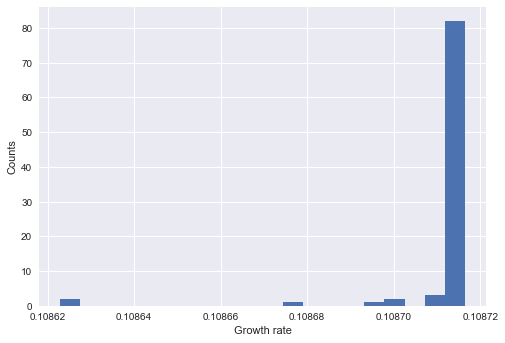

In [120]:
# Now the rest:
(n, bins, patches) = plt.hist(candidates_df.loc['biomass_dilution_s'],bins=20)
plt.xlabel('Growth rate')
plt.ylabel('Counts')

In [100]:
output = candidates_df.loc[candidates_df.columns.to_list()+['biomass_dilution_s']]
output = output[output.any(axis=1)] # Only reactions that carried flux in at least one knockout

/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:1 FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


<Figure size 936x360 with 0 Axes>

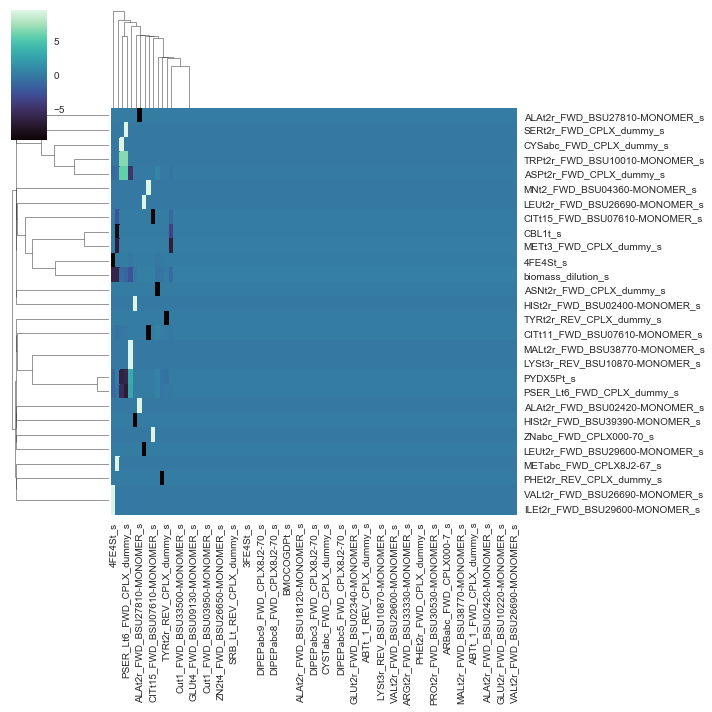

In [101]:
plt.figure(figsize = (13,5))
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
sns.clustermap(cluster_df,col_cluster=1,row_cluster=1,cmap="mako")
plt.savefig('clustermap_unfiltered')
# Check normalization Z-score, is it normalizing all elements in the matrix or only row-wise?

<Figure size 936x360 with 0 Axes>

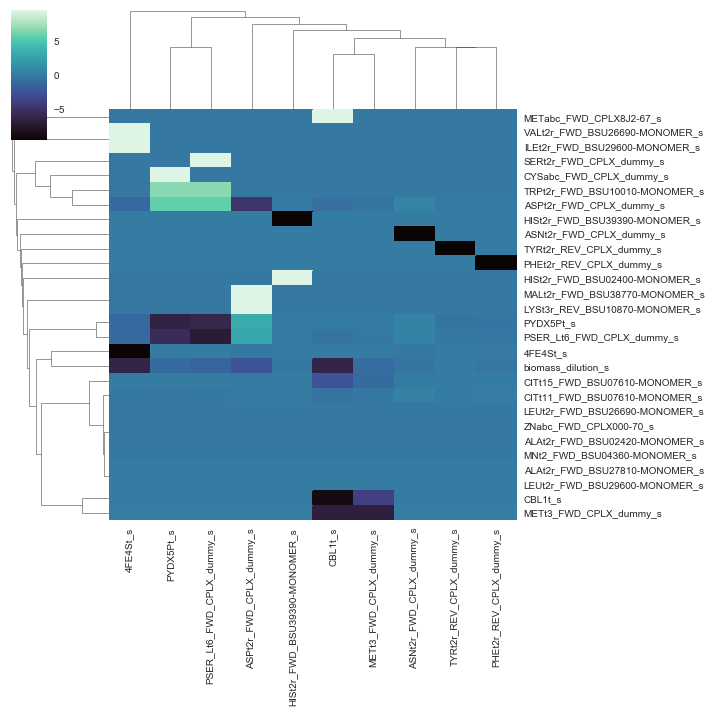

In [113]:
plt.figure(figsize = (13,5))
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
cluster_df = cluster_df.loc[:,output.loc['biomass_dilution_s']<bins[-1]]
sns.clustermap(cluster_df,col_cluster=1,row_cluster=1,cmap="mako")
plt.savefig('clustermap_filtered')

In [123]:
# 1. Pairwise interaction knockout
# 2. Find minimal set of transporters. Sort values and close less essential first. 
# Ignore those transporters that are not active. Restore them if they are turned on again to compensate.
# 3. Do these simulations change with different NGAM?

## Pairwise interaction

In [124]:
from bacillusme.analysis import sensitivity as ss
transport_reactions_filtered = cluster_df.columns.values
base_model = copy.deepcopy(sporeme)

In [125]:
from scipy.special import binom
print('With {} knockouts there can be {} pairs'.format(len(transport_reactions_filtered),binom(len(transport_reactions_filtered),2)))

With 12 knockouts there can be 66.0 pairs


In [ ]:
for r in transport_reactions_filtered:
    # Restore
    sporeme = copy.deepcopy(base_model)
    
    # Close transporter
    rxn = sporeme.reactions.get_by_id(r)
    rxn.lower_bound = 0
    rxn.upper_bound = 0
    
    # Calculation
    flux_results_df = ss.transporter_knockout(sporeme,transport_reactions_filtered, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma')
    flux_results_df.to_csv('transporter_knockouts/{}.csv'.format(r))


biomass_dilution_s response (10 threads):  83%|████████▎ | 10/12 [43:40<13:55, 417.99s/it]

In [137]:
# Read and process
gr_df = pd.DataFrame(index=transport_reactions_filtered)
for r in transport_reactions_filtered:
    flux_results_df=pd.read_csv('transporter_knockouts/{}.csv'.format(r),index_col=0).drop('base',axis=1)
    for i in transport_reactions_filtered:
        gr_df.loc[r,i] = flux_results_df.loc['biomass_dilution_s',i]

<Figure size 936x360 with 0 Axes>

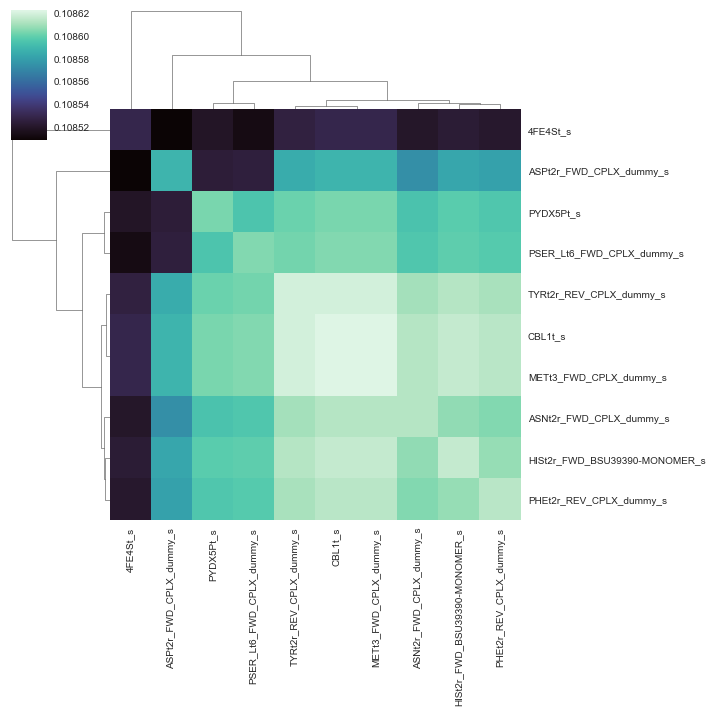

In [138]:
plt.figure(figsize = (13,5))
output = gr_df.loc[gr_df.any(axis=1),gr_df.any(axis=0)]
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
sns.clustermap(output,col_cluster=1,row_cluster=1, cmap='mako')
plt.savefig('pairwise_growth')

## Find minimal set of transporters

In [9]:
flux_results_df = pd.read_csv('comm_transport_flux_results.csv',index_col=0).drop('base',axis=1)

In [10]:
# Sort from least to most influential. Not influential do not alter growth:
sorted_transporters = flux_results_df.loc['biomass_dilution_s'].sort_values(ascending=False)

In [11]:
flux_dict = {}
flux_dict['base'] = sporeme.solution.x_dict

In [12]:
# Calculation
cutoff = 0.001
flux_dict = dict()
essential_transporters = []
i = 0
for transporter in tqdm(sorted_transporters.index):
    r = sporeme.reactions.get_by_id(transporter)
    r.lower_bound = 0
    r.upper_bound = 0
    
    solve_me_model(sporeme, max_mu = 0.5, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key = 'sigma',verbosity=0)
    if sporeme.solution:
        flux_dict[transporter] = sporeme.solution.x_dict
    else:
        flux_dict[transporter] = {r.id:0. for r in sporeme.reactions}
    
    if flux_dict[transporter]['biomass_dilution_s'] > cutoff:
        continue
    else:
        # Essential. Restore and store.
        r.lower_bound = 0
        r.upper_bound = 1000
        essential_transporters.append(transporter)
    print(transporter)

  2%|▏         | 2/93 [1:00:26<45:33:24, 1802.25s/it]

KeyboardInterrupt: 

In [ ]:
2

In [ ]:
2

### Mini robustness

In [13]:
transport_reactions = ['ASPt2r_FWD_CPLX_dummy_s','4FE4St_s','PSER_Lt6_FWD_CPLX_dummy_s','CBL1t_s']

In [ ]:
from bacillusme.analysis import sensitivity as ss
flux_results_df = ss.transporter_knockout(sporeme,transport_reactions, \
                                        NP=10,solution=1,biomass_dilution='biomass_dilution_s',\
                                        growth_key = 'sigma',overexpress=True)
flux_results_df.to_csv('overexpress_flux_results.csv')

biomass_dilution_s response (4 threads):  25%|██▌       | 1/4 [19:27<58:23, 1167.85s/it]

In [17]:
output = flux_results_df.loc[flux_results_df.columns.to_list()+['biomass_dilution_s']]
output = output[output.any(axis=1)] # Only reactions that carried flux in at least one knockout

/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:1 FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


<Figure size 936x360 with 0 Axes>

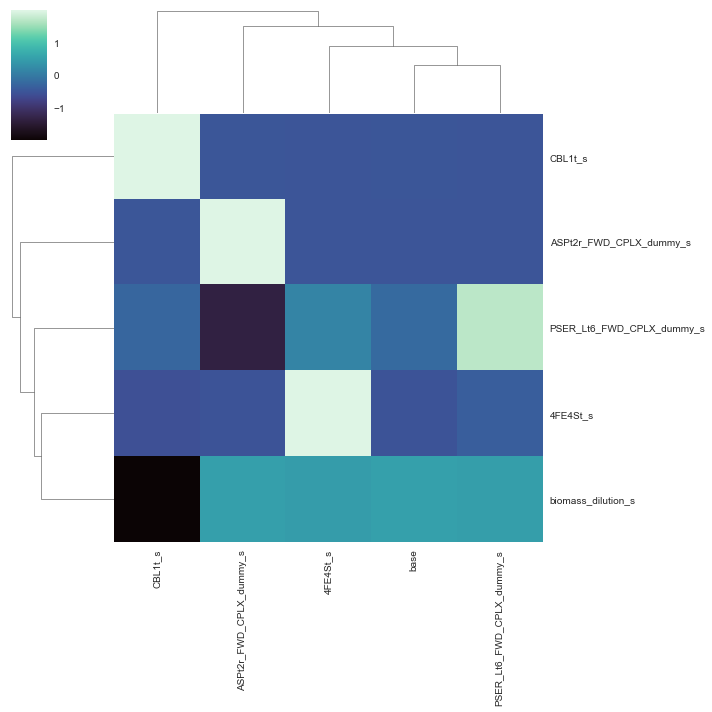

In [21]:
plt.figure(figsize = (13,5))
cluster_df = pd.DataFrame(stats.zscore(output,axis=1),
                            index=output.index,columns=output.columns)
sns.clustermap(cluster_df,col_cluster=1,row_cluster=1,cmap="mako")
plt.savefig('clustermap_filtered')